# Micro Sim Controllable Model

## Imports

In [39]:
import os
import time
import gc
from itertools import chain
import json
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass, asdict

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode, resize, affine

from diffusers import UNet2DModel, DDIMScheduler, get_cosine_schedule_with_warmup

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: parameterized. Use `wandb login --relogin` to force relogin


True

## Data processing and display setup

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'
sns.set_theme(style='darkgrid')

def display_video(path, loop=True):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'''<video src="{
        data_url}" controls=true autoplay=true {
        "loop=true " if loop else ""}/>'''))

In [4]:
# close to actual mean/std
data_mean = np.full(3, .6)
data_std = np.full(3, .1)
print(data_mean, data_std)

# norm and inverse norm transformations
norm_t = transforms.Normalize(data_mean, data_std)
invnorm_t = transforms.Normalize(-data_mean / data_std, 1 / data_std)

tensor_to_img = lambda x: Image.fromarray(
    invnorm_t(x).clip(0, 1).movedim(-3, -1).detach().cpu()
    .multiply(255).type(torch.uint8).numpy())

[0.6 0.6 0.6] [0.1 0.1 0.1]


## Data and model configuration

In [5]:
@dataclass
class Config:
    # data
    frames_path: str = 'datasets/jams-germs/frames/Buttercup the Water Bear Sees a Giant Amoeba'
    frame_count: int = None
    device: int = 'cuda'
    
    # model
    model_type: str = 'controllable'
    num_memory_x: int = 8
    num_memory_h: int = 4
    sample_size: int = 64
    img_shape: tuple = None
    layers_per_block = 2
    block_out_channels: tuple = (16, 32, 64, 128, 128)
    down_block_types: tuple = (
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    )
    up_block_types: tuple = (
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
    
    # training
    load_pretrained: bool = False
    pretrained_path: str = 'models/VideoUNet_62655314'
    pool_size: int = 64
    batch_size: int = 16
    num_batch_frames: int = 4
    num_training_steps: int = int(2e4)
    lr: float = 1e-4
    num_warmup_steps: int = int(1e3)
    
    # training visualization/saving
    loss_every_n: int = 10
    display_every_n: int = 50
    video_every_n: int = int(2e3)
    save_every_n: int = int(1e3)
    
    # noise scheduler
    noise_scheduler_type: str = 'DDIM'
    num_train_timesteps: int = 1000
    num_inference_steps: int = 16
    inference_skip: int = 0
    
    # automatically set these
    def init(self):
        self.frame_count: int = len(os.listdir(self.frames_path))
        self.img_shape = (3, self.sample_size, self.sample_size)
        return self

cf = Config().init()
asdict(cf)

{'frames_path': 'datasets/jams-germs/frames/Buttercup the Water Bear Sees a Giant Amoeba',
 'frame_count': 8331,
 'device': 'cuda',
 'model_type': 'controllable',
 'num_memory_x': 8,
 'num_memory_h': 4,
 'sample_size': 64,
 'img_shape': (3, 64, 64),
 'block_out_channels': (16, 32, 64, 128, 128),
 'down_block_types': ('DownBlock2D',
  'DownBlock2D',
  'DownBlock2D',
  'AttnDownBlock2D',
  'DownBlock2D'),
 'up_block_types': ('UpBlock2D',
  'AttnUpBlock2D',
  'UpBlock2D',
  'UpBlock2D',
  'UpBlock2D'),
 'load_pretrained': False,
 'pretrained_path': 'models/VideoUNet_62655314',
 'pool_size': 64,
 'batch_size': 16,
 'num_batch_frames': 4,
 'num_training_steps': 20000,
 'lr': 0.0001,
 'num_warmup_steps': 1000,
 'loss_every_n': 10,
 'display_every_n': 50,
 'video_every_n': 2000,
 'save_every_n': 1000,
 'noise_scheduler_type': 'DDIM',
 'num_train_timesteps': 1000,
 'num_inference_steps': 16,
 'inference_skip': 0}

In [6]:
# load tracking file
with open('datasets/track-buttercup.json', 'r') as f:
    full_track = json.load(f)

## Data sampling utilities

In [43]:
def get_batch(batch_size=cf.batch_size, start_frames=None):
    """
    Get batch of:
        images of size (batch_size, cf.num_batch_frames, *cf.img_shape),
        body position/orientation image embedding of the same size,
        and normalized camera movement of size (batch_size, cf.num_batch_frames, 2)
    """
    comp = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(512), # images are 910x512
        transforms.Resize(cf.sample_size)
    ])
    
    if start_frames is None:
        start_frames = np.random.randint(
            cf.frame_count - cf.num_batch_frames + 1, size=(batch_size,))
    
    ci, cj = torch.meshgrid(
        *[torch.arange(cf.sample_size) for _ in range(2)], 
        indexing='xy'
    )
    coords = torch.stack([ci, cj], dim=0)
    
    imgs = torch.empty(batch_size, cf.num_batch_frames, *cf.img_shape, device=cf.device)
    local_embs = torch.empty_like(imgs)
    cam_movements = torch.zeros(batch_size, cf.num_batch_frames, 2, device=cf.device)
    # batch_track = torch.empty(batch_size, cf.num_batch_frames, 4, device=cf.device)
    for i in range(batch_size):
        for j in range(cf.num_batch_frames):
            img = Image.open(f'{cf.frames_path}/{start_frames[i] + j}.jpg')
            imgs[i, j] = norm_t(comp(img))
            bx, by = full_track['body'][start_frames[i] + j]
            hx, hy = full_track['head'][start_frames[i] + j]
            
            # head offset (not rescaled but only used for angle)
            ox, oy = hx - bx, hy - by
            # transform body to sample coords
            bx = (bx - 199) / 512 * cf.sample_size
            by = by / 512 * cf.sample_size
            
            # body -> pixel
            dirs = coords - torch.tensor([bx, by])[:, None, None]
            angles = torch.atan2(dirs[1], dirs[0])
            angles = angles - np.arctan2(oy, ox)
            local_dx = angles.cos()
            local_dy = angles.sin()
            dist = (dirs[0]**2 + dirs[1]**2).sqrt() * (2 / cf.sample_size)
            local_embedding = torch.stack([
                local_dx, local_dy, 1 - dist
            ], dim=0)
            local_embs[i, j] = local_embedding
            
            # d = (ox*ox + oy*oy)**.5
            # ox /= d; oy /= d
            # bx = (bx - 199) / 512
            # by /= 512
            # batch_track[i, j] = torch.tensor([bx, by, ox, oy])
            
            if start_frames[i] + j >= 2:
                world_xys = [
                    torch.tensor(full_track['world'][start_frames[i] + j - 2 + k])
                    for k in range(3)
                ]
                if start_frames[i] + j in full_track['jumps']:
                    cam_movements[i, j] = (world_xys[1] - world_xys[0]) / 512
                else:
                    cam_movements[i, j] = (world_xys[2] - world_xys[1]) / 512
                    
    
    return imgs, local_embs, cam_movements

In [8]:
class Pool():
    def __init__(self):
        """Create pool using cf config"""
        self.size = cf.pool_size
        # low=1 so prev frame is valid
        self.start_frames = torch.randint(1,
            cf.frame_count - cf.num_batch_frames + 1, size=(self.size,))
        self.memory = torch.randn(
            self.size, cf.num_memory_h, *cf.img_shape[1:], device=cf.device)
        self.is_first = torch.full((self.size,), True, device=cf.device)
    
    def init(self, indices=None):
        """Re-initialize entire pool or at given indices"""
        if len(indices) == 0:
            return
        if indices is None:
            indices = torch.arange(self.size)
        
        self.start_frames[indices] = torch.randint(1,
            cf.frame_count - cf.num_batch_frames + 1, size=(len(indices),))
        self.memory[indices] = torch.randn(
            len(indices), cf.num_memory_h, *cf.img_shape[1:], device=cf.device)
        self.is_first[indices] = True
    
    def sample(self, indices):
        """
        Sample start_frames, memory at indices
        Returns: start_frames, memory, is_first
        """
        # replace 1/4 of batch with new samples
        self.init(indices[:len(indices) // 4])
        return self.start_frames[indices], self.memory[indices], self.is_first[indices]
    
    def replace(self, indices, start_frames, memory):
        """Replace start_frames, memory at indices and update is_first"""
        self.start_frames[indices] = start_frames + cf.num_batch_frames
        self.memory[indices] = memory
        self.is_first[indices] = False
        # re-init if end reached
        self.init(indices[start_frames >= cf.frame_count - cf.num_batch_frames * 2])

## Visualize data sampling

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88it/s]


Moviepy - Building video output/train_set_buttercup.mp4.
Moviepy - Writing video output/train_set_buttercup.mp4



Moviepy - Done !
Moviepy - video ready output/train_set_buttercup.mp4


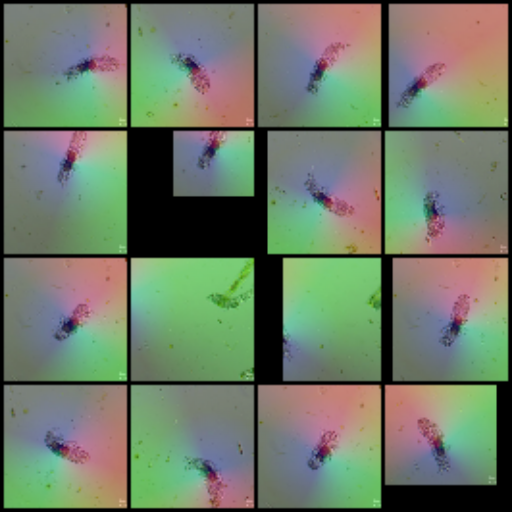

In [64]:
def gen_trainset_video(path, fps=25):
    tqdm._instances.clear()
    tp = Pool()
    perm = torch.arange(16)
    full_clip = torch.empty(16, 4 * 20, *cf.img_shape)
    # full_track = torch.empty(*full_clip.shape[:2], 4)
    full_local_embs = torch.empty_like(full_clip)
    full_cam_movements = torch.empty_like(full_clip[:, :, :2, 0, 0])
    first_frames = torch.zeros_like(full_clip[:, :, 0, 0, 0]).bool()
    for i in tqdm(range(full_clip.shape[1] // 4)):
        # first 1/4 gets replaced with new samples
        start_frames, memory, is_first = tp.sample(perm)
        x0s, local_embs, cam_movements = get_batch(16, start_frames)
        full_clip[:, 4 * i:4 * (i + 1)] = x0s
        # full_track[:, 4 * i:4 * (i + 1)] = track
        full_local_embs[:, 4 * i:4 * (i + 1)] = local_embs
        full_cam_movements[:, 4 * i:4 * (i + 1)] = cam_movements
        first_frames[is_first, 4 * i] = True
        tp.replace(perm, start_frames, memory)
    
    full_clip = invnorm_t(full_clip)
    
    def make_frame(frame_state):
        if frame_state['first_frame']:
            frame_state['first_frame'] = False
            return np.zeros((512, 512, 3), dtype=np.int8)
        
        i = frame_state['i']
        frame = (full_clip[:, i] * 255).type(torch.uint8)
        frame_state['cam_movements'] += full_cam_movements[:, i]
        frame_state['cam_movements'][first_frames[:, i]] = 0
#         keypoints = full_track[:, i, None, :2] * cf.sample_size
#         keypoints = torch.cat([
#             keypoints,
#             keypoints + full_track[:, i, None, 2:] * 20
#         ], dim=1)
        
#         ci, cj = torch.meshgrid(
#             *[torch.arange(cf.sample_size) for _ in range(2)], 
#             indexing='xy'
#         )
#         coords = torch.stack([ci, cj], dim=0)
        
        for j in range(frame.shape[0]):
            # for k in range(2):
            #     frame[j] = torchvision.utils.draw_keypoints(
            #         frame[j], keypoints[j:j+1, k:k+1],
            #         colors=['deepskyblue', 'tomato'][k], radius=2
            #     )
            
            # # body -> pixel
            # dirs = coords - keypoints[j, 0, :, None, None]
            # angles = torch.atan2(dirs[1], dirs[0])
            # # orientation
            # oxoy = full_track[j][i][2:]
            # angles = angles - torch.atan2(oxoy[1], oxoy[0])
            # local_dx = angles.cos()
            # local_dy = angles.sin()
            # dist = (dirs[0]**2 + dirs[1]**2).sqrt() * (2 / cf.sample_size)
            # local_embedding = torch.stack([
            #     local_dx, local_dy, 1 - dist
            # ], dim=0)
            # frame[j] = .7 * frame[j] + .3 * 255 * local_embedding.clip(0, 1)
            cm = (-frame_state['cam_movements'][j] * cf.sample_size + .5).int().tolist()
            frame[j] = affine(frame[j], 0, cm, 1, [0, 0], InterpolationMode.BILINEAR)
            frame[j] = .7 * frame[j] + .3 * 255 * affine(
                full_local_embs[j, i].clip(0, 1),
                0, cm, 1, [0, 0], InterpolationMode.BILINEAR
            )
        
        frame = torchvision.utils.make_grid(frame / 255, nrow=4)
        frame_state['i'] = min(i + 1, full_clip.shape[1] - 1)
        frame = resize(frame, 512).permute(1, 2, 0)
        return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {
        'i': 0, 'first_frame': True,
        'cam_movements': torch.zeros_like(full_cam_movements[:, 0])
    }
    clip = mpy.VideoClip(lambda t: make_frame(frame_state),
                         duration=full_clip.shape[1] / fps)
    clip.write_videofile(path, fps=fps)
    return clip

clip_path = 'output/train_set_buttercup.mp4'
clip = gen_trainset_video(clip_path)
display_video(clip_path, loop=True)

display.display(Image.fromarray(
    clip.get_frame(4 * 20 / 25).astype(np.uint8)
).resize((512, 512)))